In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time
import lmdb
from torch.utils.data import DataLoader
from data.dataloader import get_loaders, get_eval_loader
from data.dataset import ICDR2015Dataset, TransformDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from shapely.geometry import Polygon
from data.process.utils import get_maps
from torchvision.ops import FeaturePyramidNetwork
import torch.nn.functional as F
from fast import FAST
from shapely.geometry import Polygon
from shapely.validation import explain_validity, make_valid
from models.utils import get_metrics, evaluate

%load_ext autoreload
%autoreload 2

In [68]:
train_loader, val_loader = get_loaders('data', batch_size=16, train=True)

In [63]:
model = FAST().cuda()
checkpoint = torch.load('models/checkpoints/fast_216', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
checkpoint['epoch']

250

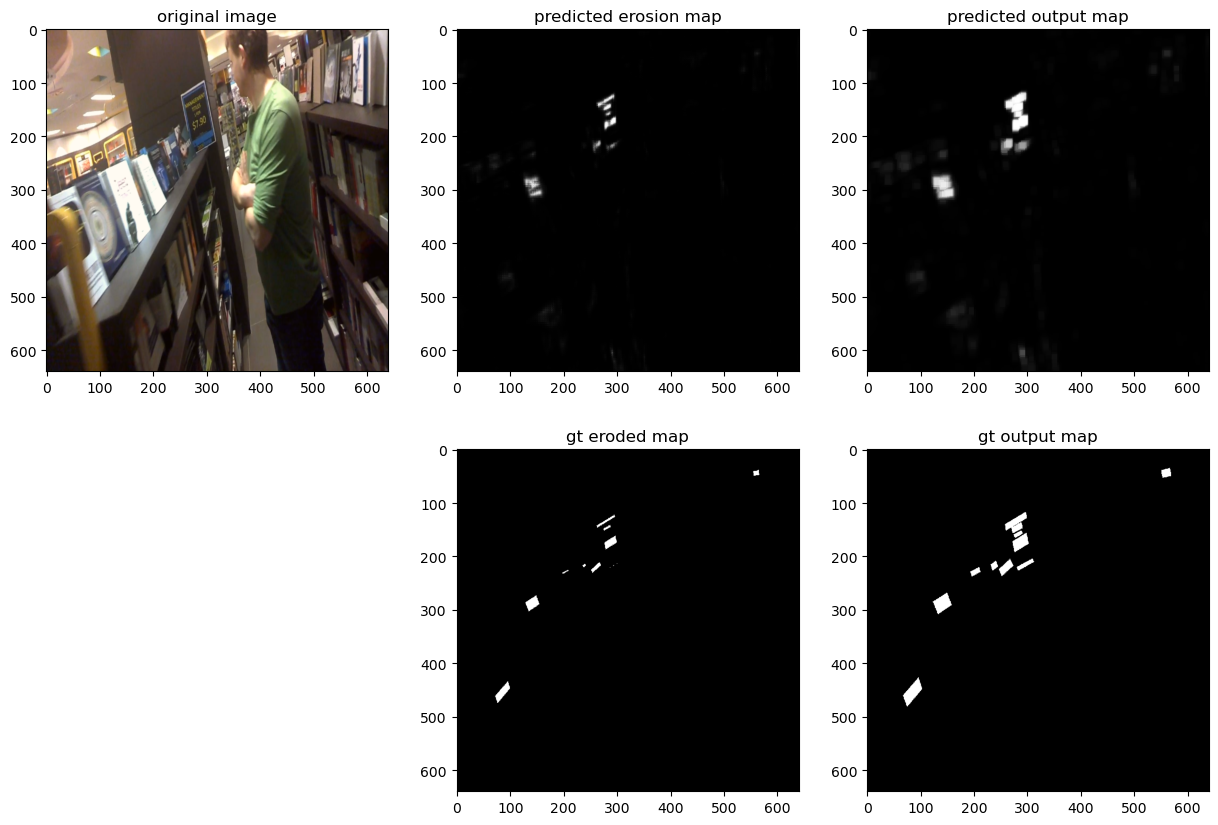

In [64]:
images, maps = next(iter(train_loader))

i = 0
image, gt_map, eroded_map = images[i].cuda().unsqueeze(0), maps['gt_maps'][i].cuda().unsqueeze(0), maps['eroded_maps'][i].cuda().unsqueeze(0)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.delaxes(axs[1][0])

model.eval()
out = model(image, eroded_map, gt_map)['output']
out2 = F.max_pool2d(out, 9, stride=1, padding=4)

axs[0][0].imshow(((image - image.min()) / (image.max() - image.min())).cpu().squeeze().permute(1, 2, 0))
axs[0][0].set_title('original image')

axs[0][1].imshow(out.detach().cpu().squeeze(), vmin=0, vmax=1, cmap='gray')
axs[0][1].set_title('predicted erosion map')
axs[0][2].imshow(out2.detach().cpu().squeeze(), vmin=0, vmax=1, cmap='gray')
axs[0][2].set_title('predicted output map')

axs[1][1].imshow(eroded_map.detach().cpu().squeeze(), vmin=0, vmax=1, cmap='gray')
axs[1][1].set_title('gt eroded map')
axs[1][2].imshow(gt_map.detach().cpu().squeeze(), vmin=0, vmax=1, cmap='gray')
axs[1][2].set_title('gt output map')
plt.show()

In [70]:
evaluate(model, val_loader)

100%|██████████| 19/19 [00:26<00:00,  1.37s/it]

Precision: 0.4428 | Recall: 0.4809 | F1: 0.4258


In [69]:
evaluate(model, train_loader)

  0%|          | 0/75 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:51<00:00,  1.47it/s]

Precision: 0.5293 | Recall: 0.6219 | F1: 0.5337
